
## Data Initializing

In [55]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from multiprocessing import Pool
import pickle
from itertools import permutations
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import importlib
importlib.reload(dh)
importlib.reload(md)

In [ ]:
import numba
numba.__version__

In [ ]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

# Beckmann model

parameter $\mu = 0.25$

In [ ]:
beckmann_save = 'beckmann_results/'

In [ ]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

graph_data['graph_table'].head()

In [ ]:
epsilons = np.logspace(3,1.5,7)
epsilons
results = {}

In [ ]:
def compute(kwargs):
    tic = time.time()
    result = model.find_equilibrium(**kwargs)
    toc = time.time()
    return {'args': kwargs, 'result': result, 'time': toc - tic}

def find_eq_for_list(arg_list):
    pool = Pool(processes=len(arg_list))
    return pool.map(compute, arg_list)

In [ ]:
def single_solver(solver_name, step=2000):
    arg_list = []
    for i in range(10):
        kwargs = {}
        max_iter = step * (i + 1)
        kwargs['solver_kwargs'] = {'max_iter' : max_iter, 'stop_crit': 'max_iter',
                    'verbose' : False, 'verbose_step': 2000, 'save_history' : True}
        kwargs['solver_name'] = solver_name
        kwargs['composite'] = True
        arg_list.append(kwargs)
    local_results = find_eq_for_list(arg_list)
    for args, res in zip(arg_list, local_results):
        max_iter = args['solver_kwargs']['max_iter']
        results[args['solver_name'] + str(max_iter)] = res

In [ ]:
def solvers_combination(first_solver, second_solver, step=2000):
    arg_list = []
    prev_labels = []
    for i in range(10):
        iters_passed = i * step
        
        max_iter = (10 * step - iters_passed)
        kwargs = {}
        kwargs['solver_kwargs'] = {'max_iter' : max_iter, 'stop_crit': 'max_iter',
                    'verbose' : False, 'verbose_step': 2000, 'save_history' : True}
        kwargs['solver_name'] = second_solver
        kwargs['composite'] = True
        if iters_passed > 0:
            prev_label = first_solver + str(iters_passed) if iters_passed > 0 else None
            prev_res = results[prev_label]
            prev_labels.append(prev_label)
            kwargs['t_start'] = prev_res['result']['times']
        else:
            prev_labels.append(None)
        arg_list.append(kwargs)
    local_results = find_eq_for_list(arg_list)

    for args, res, prev_label in zip(arg_list, local_results, prev_labels):
        max_iter = args['solver_kwargs']['max_iter']
        if prev_label is not None:
            res['prev_res'] = prev_label
            results[prev_label + '+' + args['solver_name'] + str(max_iter)] = res
        else:
            results[args['solver_name'] + str(max_iter)] = res

In [ ]:
solvers = ['fwm', 'ustm', 'wda', 'ugd']


In [ ]:
for solver in solvers:
    single_solver(solver)

In [ ]:
for label, res in results.items():
    print(label, res['result']['history']['dual_gap'][-1])

In [ ]:
for first_solver, second_solver in permutations(solvers, 2):
    print(first_solver, second_solver)
    solvers_combination(first_solver, second_solver)

In [ ]:
# with open('anaheim_result_new_start_beckmann.pickle', 'wb') as f:
#     pickle.dump(results, f)

In [ ]:
with open('anaheim_result_new_start_beckmann.pickle', 'rb') as f:
        loaded_results = pickle.load(f)
results = loaded_results

In [ ]:
x = np.linspace(0, 20000, 11, endpoint=True, dtype=int)
dual_gaps = {}
for first_solver, second_solver in permutations(solvers, 2):
    if first_solver not in dual_gaps.keys():
        dual_gaps[first_solver] = {}
    dual_gaps[first_solver][second_solver] = []
    for first_iters in x:
        second_iters = 20000 - first_iters
        if first_iters == 0:
            label = second_solver + str(second_iters)
        elif second_iters == 0:
            label = first_solver + str(first_iters)
        else:
            label = first_solver + str(first_iters) + '+' + second_solver + str(second_iters)
        if label in results.keys():
            dual_gap = results[label]['result']['history']['dual_gap'][-1]
            dual_gaps[first_solver][second_solver].append(dual_gap)

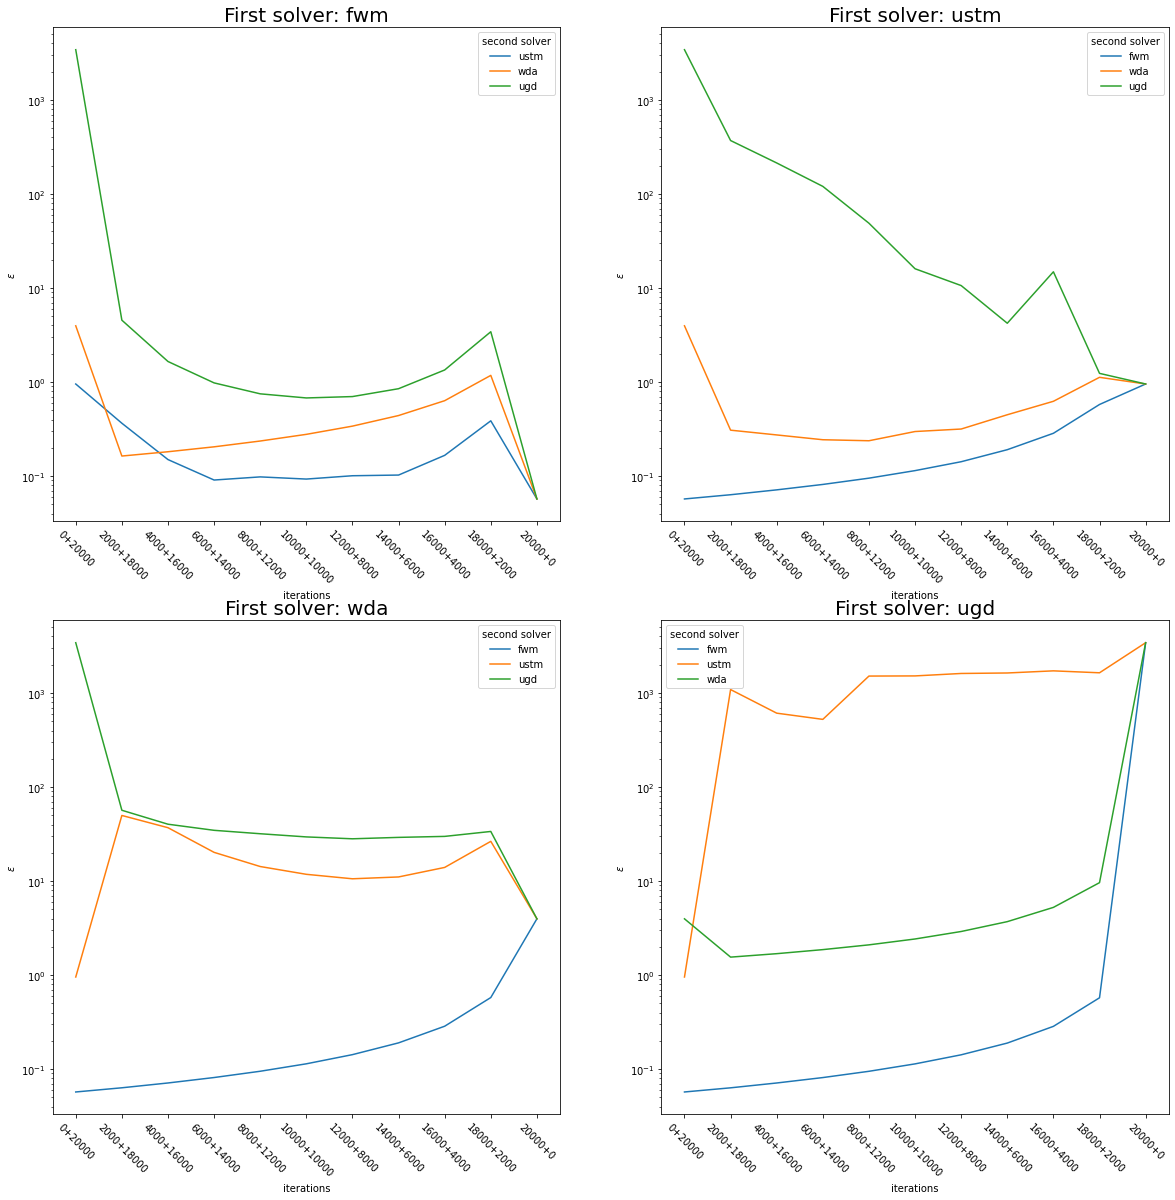

In [56]:
def draw_plot(first_solver, plot):
    for second_solver in solvers:
        if second_solver == first_solver:
            continue
        y = dual_gaps[first_solver][second_solver]
        plot.set_title('First solver: ' + first_solver, fontsize=20)
        if len(y) == 2:
            plot.plot([x[0], x[-1]], y, label = second_solver)
        else:
            plot.plot(x, y, label = second_solver)
        plot.legend(title = 'second solver')
        plot.set_ylabel(r'$\varepsilon$')
        plot.set_xlabel('iterations')
        plot.set_xticklabels(['']+[str(iters) + '+' + str (20000 - iters)for iters in x]+[''], rotation=-45)
        plot.locator_params(axis='x', nbins=12)
        plot.set_yscale('log')

fig, axs = plt.subplots(2, 2, figsize=(20.,20.))
draw_plot('fwm', axs[0][0])
draw_plot('ustm', axs[0][1])
draw_plot('wda', axs[1][0])
draw_plot('ugd', axs[1][1])
plt.show()

In [ ]:
for label, res in results.items():
    print(label, res['result']['history']['dual_gap'][-1])